## Prédiction du Risque de Crédit : Comparaison de trois Modèles d’Apprentissage Supervisé

## Problématique

#### Dans un contexte bancaire, l’évaluation du risque de crédit est essentielle pour minimiser les défauts de paiement tout en garantissant un processus d’octroi de crédit équitable et fiable.
#### Face à un ensemble de données décrivant des clients avec des caractéristiques socio-démographiques, financières et comportementales, comment construire un modèle prédictif permettant de classer efficacement les clients en bons ou mauvais risques de crédit , en tenant compte du déséquilibre des classes ?
#### Quel modèle parmi la régression logistique , l’arbre de décision et la forêt aléatoire offre le meilleur compromis entre performance, interprétabilité et robustesse ? 

In [1]:
# 📚 Librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
# 🧪 Statistiques : Chi-2 et ANOVA
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
# 🛠️ Prétraitement
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline  # Pour intégrer SMOTE
# 📊 Sélection des données
from sklearn.model_selection import train_test_split
# 📈 Métriques d'évaluation
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score
)
# 🔍 Modèles ML
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# 🔍 Optimisation des hyperparamètres
from sklearn.model_selection import GridSearchCV, cross_validate
# 💾 Rééquilibrage de classes
from imblearn.over_sampling import SMOTE

## Importation des données 

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 
  
# metadata 
print(statlog_german_credit_data.metadata) 
  
# variable information 
print(statlog_german_credit_data.variables) 

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

## Étape 1 : Analyse Exploratoire des Données (EDA)

## L'objectif :
Comprendre la structure des données, détecter les valeurs manquantes, les déséquilibres de classes, les distributions des variables, et identifier les prétraitements nécessaires.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping des anciens noms vers des noms explicites
column_mapping = {
    'Attribute1': 'Status_checking_account',
    'Attribute2': 'Duration_months',
    'Attribute3': 'Credit_history',
    'Attribute4': 'Purpose',
    'Attribute5': 'Credit_amount',
    'Attribute6': 'Savings_account',
    'Attribute7': 'Employment_since',
    'Attribute8': 'Installment_rate',
    'Attribute9': 'Personal_status_sex',
    'Attribute10': 'Other_debtors',
    'Attribute11': 'Residence_since',
    'Attribute12': 'Property',
    'Attribute13': 'Age_years',
    'Attribute14': 'Other_installment_plans',
    'Attribute15': 'Housing',
    'Attribute16': 'Num_credits',
    'Attribute17': 'Job',
    'Attribute18': 'Liable_people',
    'Attribute19': 'Telephone',
    'Attribute20': 'Foreign_worker'
}

# Renommer les colonnes
X = X.rename(columns=column_mapping)

# Aperçu des données
print("Shape of X:", X.shape)
print("Target distribution:\n", y.value_counts())

# Affichage des 5 premières lignes
display(X.head())

# Vérification des types de variables
print("\nData types:")
print(X.dtypes)

# Vérification des valeurs manquantes
print("\nMissing values:")
print(X.isnull().sum())

# Statistiques descriptives
display(X.describe(include='all'))

Shape of X: (1000, 20)
Target distribution:
 class
1        700
2        300
Name: count, dtype: int64


,Status_checking_account,Duration_months,Credit_history,Purpose,Credit_amount,Savings_account,Employment_since,Installment_rate,Personal_status_sex,Other_debtors,Residence_since,Property,Age_years,Other_installment_plans,Housing,Num_credits,Job,Liable_people,Telephone,Foreign_worker
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201



Data types:
Status_checking_account    object
Duration_months             int64
Credit_history             object
Purpose                    object
Credit_amount               int64
Savings_account            object
Employment_since           object
Installment_rate            int64
Personal_status_sex        object
Other_debtors              object
Residence_since             int64
Property                   object
Age_years                   int64
Other_installment_plans    object
Housing                    object
Num_credits                 int64
Job                        object
Liable_people               int64
Telephone                  object
Foreign_worker             object
dtype: object

Missing values:
Status_checking_account    0
Duration_months            0
Credit_history             0
Purpose                    0
Credit_amount              0
Savings_account            0
Employment_since           0
Installment_rate           0
Personal_status_sex        0
Other_debtors  

,Status_checking_account,Duration_months,Credit_history,Purpose,Credit_amount,Savings_account,Employment_since,Installment_rate,Personal_status_sex,Other_debtors,Residence_since,Property,Age_years,Other_installment_plans,Housing,Num_credits,Job,Liable_people,Telephone,Foreign_worker
count,1000,1000.000000,1000,1000,1000.000000,1000,1000,1000.000000,1000,1000,1000.000000,1000,1000.000000,1000,1000,1000.000000,1000,1000.000000,1000,1000
unique,4,NaN,5,10,NaN,5,5,NaN,4,3,NaN,4,NaN,3,3,NaN,4,NaN,2,2
top,A14,NaN,A32,A43,NaN,A61,A73,NaN,A93,A101,NaN,A123,NaN,A143,A152,NaN,A173,NaN,A191,A201
freq,394,NaN,530,280,NaN,603,339,NaN,548,907,NaN,332,NaN,814,713,NaN,630,NaN,596,963
mean,NaN,20.903000,NaN,NaN,3271.258000,NaN,NaN,2.973000,NaN,NaN,2.845000,NaN,35.546000,NaN,NaN,1.407000,NaN,1.155000,NaN,NaN
std,NaN,12.058814,NaN,NaN,2822.736876,NaN,NaN,1.118715,NaN,NaN,1.103718,NaN,11.375469,NaN,NaN,0.577654,NaN,0.362086,NaN,NaN
min,NaN,4.000000,NaN,NaN,250.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,19.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
25%,NaN,12.000000,NaN,NaN,1365.500000,NaN,NaN,2.000000,NaN,NaN,2.000000,NaN,27.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
50%,NaN,18.000000,NaN,NaN,2319.500000,NaN,NaN,3.000000,NaN,NaN,3.000000,NaN,33.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
75%,NaN,24.000000,NaN,NaN,3972.250000,NaN,NaN,4.000000,NaN,NaN,4.000000,NaN,42.000000,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN


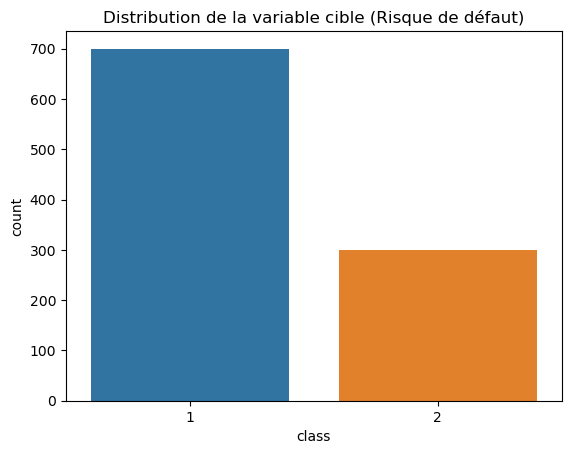

In [4]:
# Si y est un DataFrame avec une seule colonne
target_name = y.columns[0] if isinstance(y, pd.DataFrame) else None
y_series = y[target_name] if target_name else y

# Affichage de la distribution de la variable cible
sns.countplot(x=y_series)
plt.title("Distribution de la variable cible (Risque de défaut)")
plt.show()


In [5]:

# Comptage des valeurs
value_counts = y_series.value_counts()
total = value_counts.sum()

# Création du DataFrame avec pourcentage
distribution_df = pd.DataFrame({
    'Classe': value_counts.index,
    'Effectif': value_counts.values,
    'Pourcentage (%)': (value_counts.values / total * 100).round(2)
})

# Réindexer pour avoir une lecture plus claire (optionnel)
distribution_df = distribution_df.set_index('Classe').reindex([1, 2])
distribution_df.index.names = ['Classe']
distribution_df = distribution_df.reset_index()

# Affichage du tableau
print("📊 Distribution de la variable cible :")
display(distribution_df.style.background_gradient(cmap='Blues').format(precision=2))

📊 Distribution de la variable cible :


,Classe,Effectif,Pourcentage (%)
0,1,700,70.00
1,2,300,30.00


## Analyse Bivariée

### Matrice de corrélation pour les variables numériques

Variables numériques : ['Duration_months', 'Credit_amount', 'Installment_rate', 'Residence_since', 'Age_years', 'Num_credits', 'Liable_people']


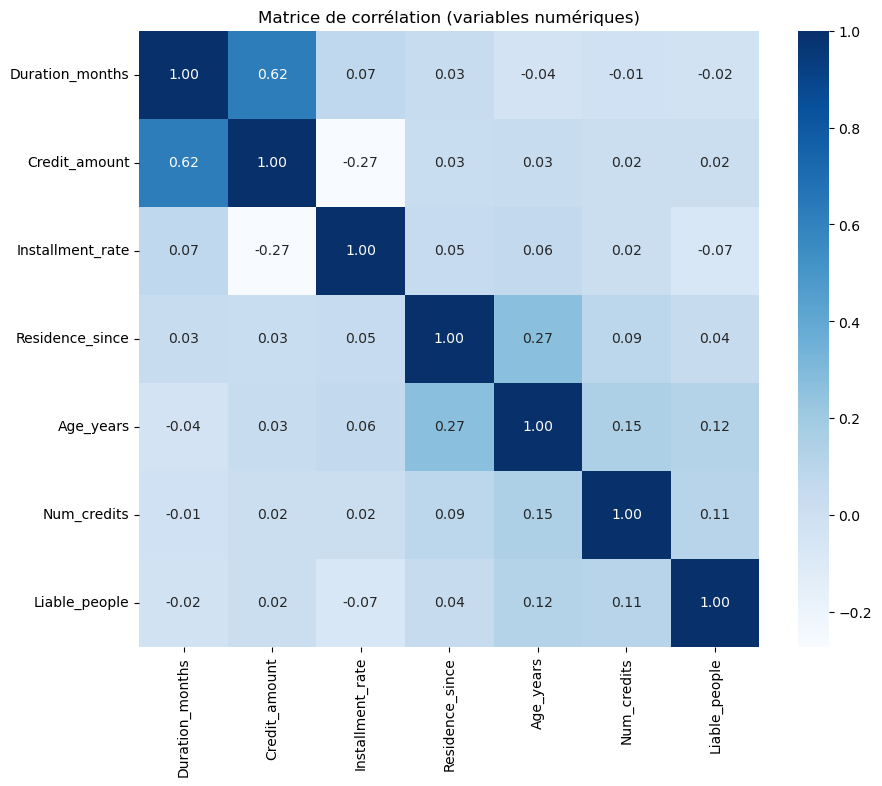

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# Supposons que ton jeu de données s'appelle 'X' (ou 'data')
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Variables numériques :", numerical_features)
# Corrélation sur les variables numériques
plt.figure(figsize=(10, 8))
sns.heatmap(X[numerical_features].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de corrélation (variables numériques)")
plt.show()


### Distribution des variables numériques par classe

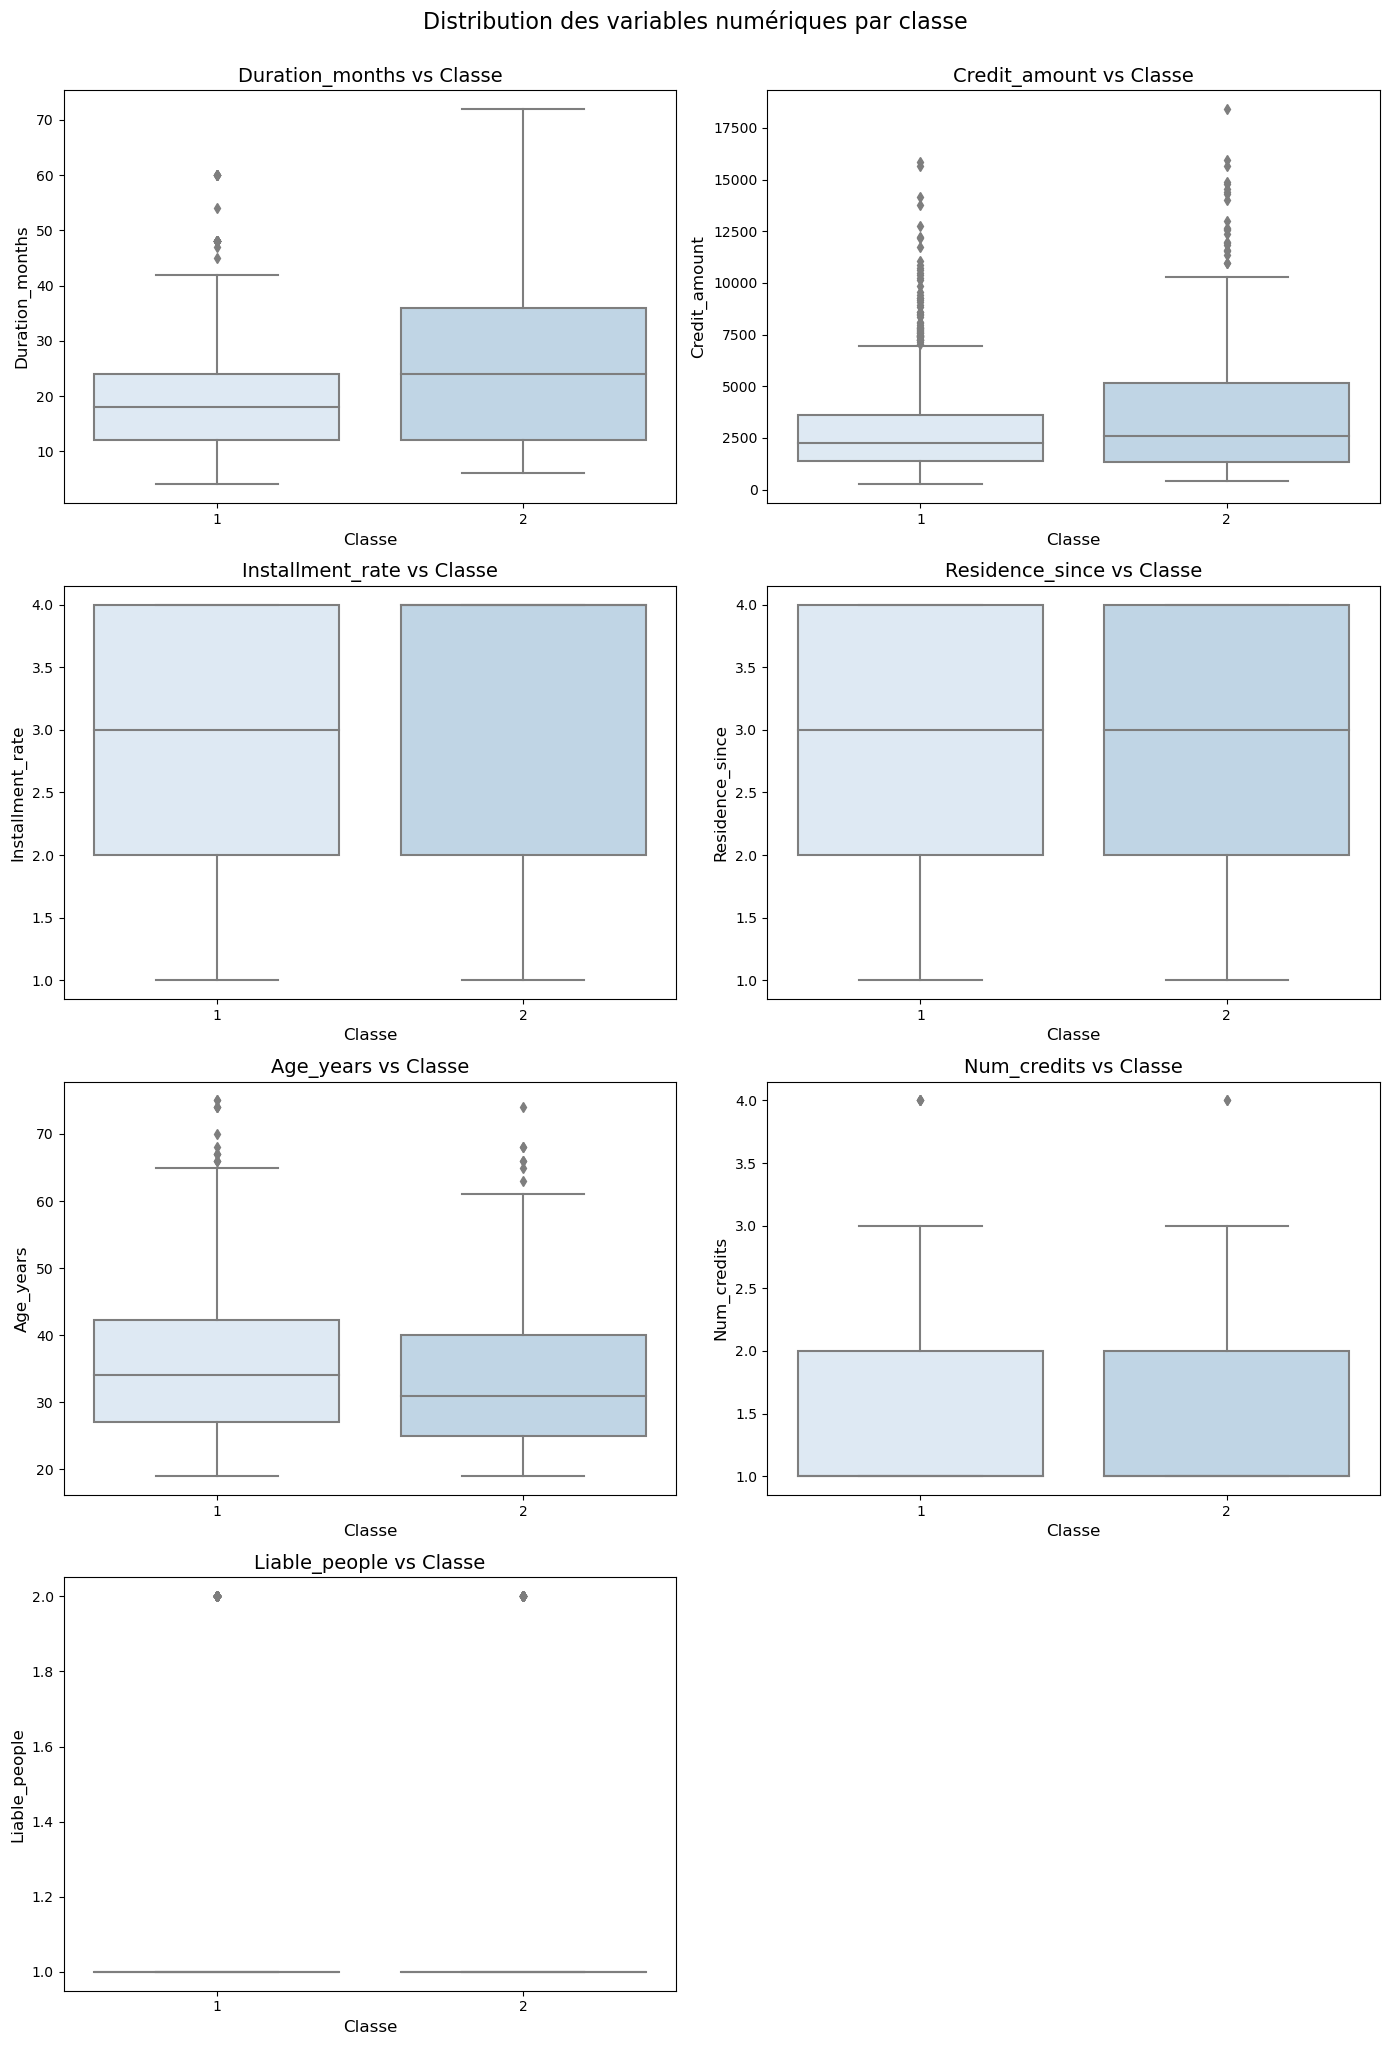

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assure-toi que numerical_features est bien définie
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Nombre de colonnes à afficher par ligne
n_cols = 2
n_rows = len(numerical_features) // n_cols + (len(numerical_features) % n_cols > 0)

# Créer la figure globale
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 5))
axes = axes.flatten()  # Pour itérer facilement

# Palette de couleurs (tu peux changer "viridis" par "Set2", "coolwarm", etc.)
palette = sns.color_palette("Blues")

# Boucle sur chaque variable numérique
for i, col in enumerate(numerical_features):
    sns.boxplot(ax=axes[i], x=y_series, y=X[col], palette=palette)
    axes[i].set_title(f"{col} vs Classe", fontsize=14)
    axes[i].set_xlabel("Classe", fontsize=12)
    axes[i].set_ylabel(col, fontsize=12)
    axes[i].tick_params(labelsize=10)

# Supprimer les sous-graphiques vides si nécessaire
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajuster l'espacement
plt.tight_layout()
plt.suptitle("Distribution des variables numériques par classe", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.98)
plt.show()

### Test d'ANOVA

In [8]:
import pandas as pd
from scipy.stats import f_oneway

# Liste des variables à tester
variables = ['Installment_rate', 'Residence_since', 'Num_credits']
results = {}

# ANOVA pour chaque variable
for var in variables:
    group1 = X[y_series == 1][var]
    group2 = X[y_series == 2][var]
    stat, p_value = f_oneway(group1, group2)
    results[var] = p_value

# Affichage des résultats
for var, p in results.items():
    print(f"{var} : p-value = {p:.4f}")


Installment_rate : p-value = 0.0220
Residence_since : p-value = 0.9253
Num_credits : p-value = 0.1484


### Distribution des variables catégorielles par classe

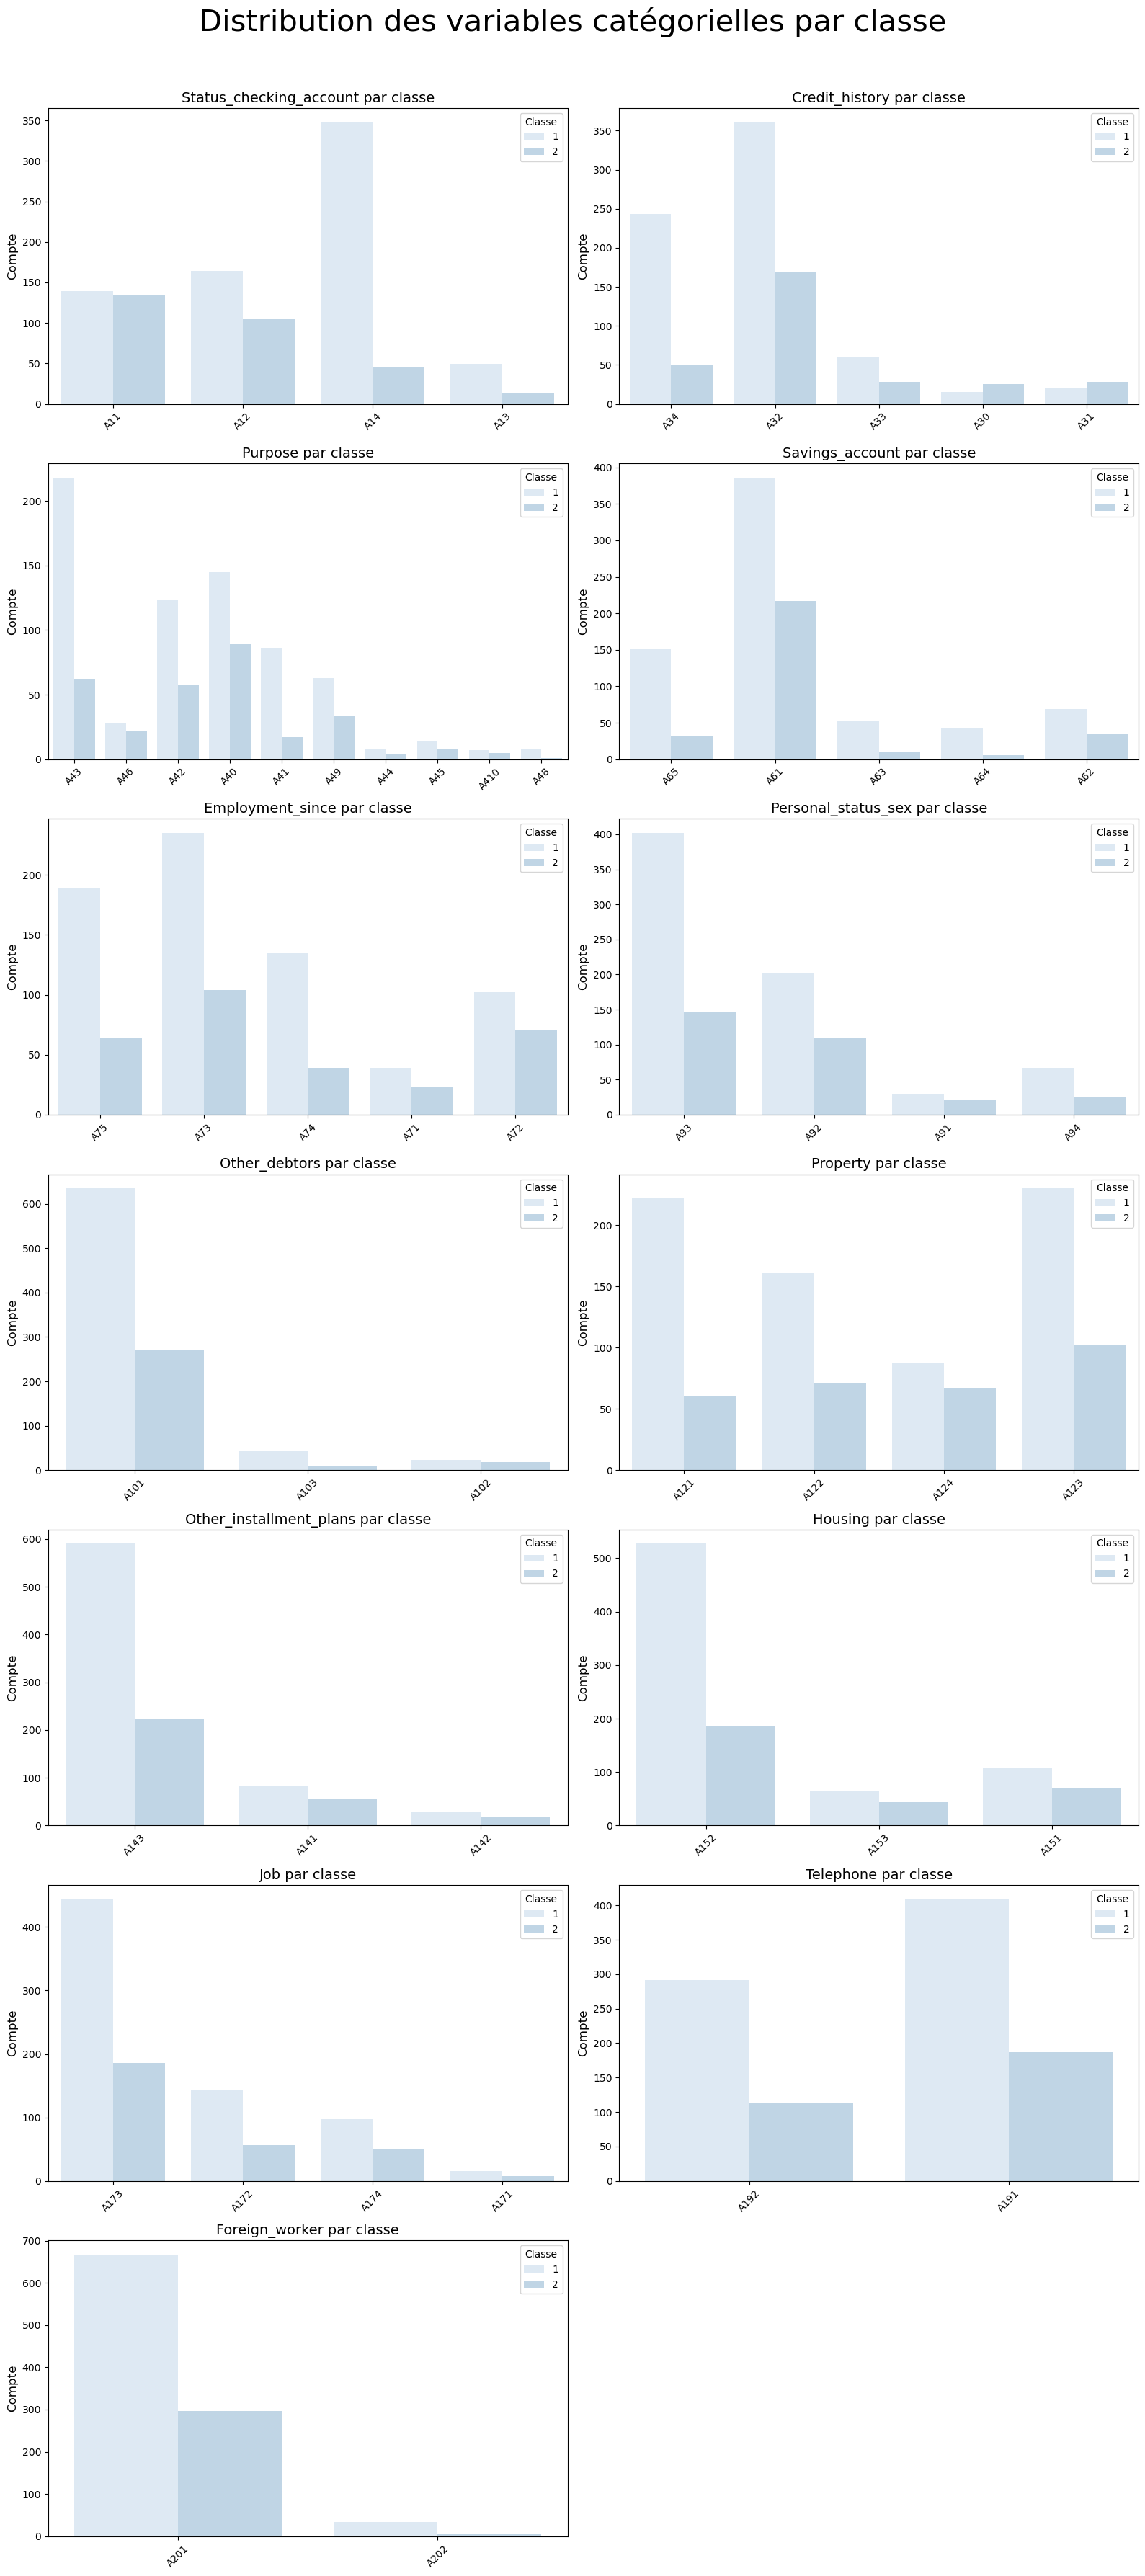

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assure-toi que categorical_features est définie
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Configuration de la grille
n_cols = 2
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

# Créer la figure globale
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten()  # Pour itérer facilement

# Palette de couleurs
palette = sns.color_palette("Blues")

# Boucle sur chaque variable catégorielle
for i, col in enumerate(categorical_features):
    sns.countplot(ax=axes[i], data=X.assign(target=y_series), x=col, hue='target', palette=palette)
    axes[i].set_title(f"{col} par classe", fontsize=14)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Compte", fontsize=12)
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].legend(title="Classe")

# Supprimer les axes vides s'il y en a
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distribution des variables catégorielles par classe", fontsize=30, y=1.02)
plt.subplots_adjust(top=0.98)
plt.show()




### Teste de khi-deux pour les variables catégorielle par rapport au variable cible

In [10]:
from scipy.stats import chi2_contingency
import pandas as pd

categorical_features = X.select_dtypes(include=['object']).columns.tolist()

#Calcul des tests du Chi-2

chi2_results = {}

for feature in categorical_features:
    try:
        # Créer la table de contingence
        contingency_table = pd.crosstab(X[feature], y_series)

        # Vérifier qu'il n'y a pas de cellules avec moins de 5 occurrences
        if (contingency_table.values < 5).any():
            print(f"⚠️ Valeur(s) trop faible(s) dans {feature}, test non fiable")
            continue

        # Appliquer le test du Chi-2
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        # Stocker les résultats
        chi2_results[feature] = {
            'chi2': chi2,
            'p_value': p,
            'significant': p < 0.05,
            'dof': dof
        }

    except Exception as e:
        print(f"❌ Erreur lors du test pour {feature} : {e}")

# Création du DataFrame final

if chi2_results:
    chi2_df = pd.DataFrame(chi2_results).T
    chi2_df.index.name = 'Variable'
    chi2_df = chi2_df.sort_values(by='p_value', ascending=True)
else:
    print("🚫 Aucune variable significative trouvée ou erreur dans les données.")
    chi2_df = pd.DataFrame()  # Créer un DataFrame vide

#Stylisation conditionnelle

def highlight_significant(s):
    return ['background-color: Blues' if s['significant'] else '' for _ in s]

if not chi2_df.empty:
    styled_chi2 = (
        chi2_df.style
        .apply(highlight_significant, axis=1)
        .background_gradient(subset=['chi2', 'p_value'], cmap='Blues')
        .format({'significant': lambda x: '✔️' if x else '❌', 'p_value': '{:.3f}', 'chi2': '{:.3f}'})
        .set_caption("Test du Chi² : relation entre variables catégorielles et la cible")
    )
    display(styled_chi2)
else:
    print("Aucune variable ne peut être affichée après le filtrage.")

⚠️ Valeur(s) trop faible(s) dans Purpose, test non fiable
⚠️ Valeur(s) trop faible(s) dans Foreign_worker, test non fiable


,chi2,p_value,significant,dof
Variable,,,,
Status_checking_account,123.721,0.000,✔️,3
Credit_history,61.691,0.000,✔️,4
Savings_account,36.099,0.000,✔️,4
Property,23.720,0.000,✔️,3
Housing,18.200,0.000,✔️,2
Employment_since,18.368,0.001,✔️,4
Other_installment_plans,12.839,0.002,✔️,2
Personal_status_sex,9.605,0.022,✔️,3
Other_debtors,6.645,0.036,✔️,2


## Étape 2 : Nettoyage des données

In [11]:
# Liste des variables à supprimer :
# - Faible pouvoir discriminant (détecté via IV et Chi-2)
# - Redondantes ou peu informatives

cols_to_remove = [
    'Installment_rate',     # Peu informative 
    'Residence_since',    # Non significative (ANOVA)
    'Other_installment_plans',    # Peu informative
    'Num_credits',    # Non significative (ANOVA)
    'Other_debtors',    # Peu informative
    'Job',    # non significative
    #'Telephone',    # non significative (Chi-2) mais a garder, certaines variables peuvent ne pas être significatives individuellement, mais contribuer en interaction avec d'autres (effet combiné)
    'Liable_people'
]

# Suppression des colonnes
X_cleaned = X.drop(columns=cols_to_remove)


# Optionnel : afficher les colonnes restantes pour vérification
print("✅ Colonnes restantes :", list(X_cleaned.columns))

✅ Colonnes restantes : ['Status_checking_account', 'Duration_months', 'Credit_history', 'Purpose', 'Credit_amount', 'Savings_account', 'Employment_since', 'Personal_status_sex', 'Property', 'Age_years', 'Housing', 'Telephone', 'Foreign_worker']


### Traitement des outliers avec la méthode IQR (pour Attribute2 et Attribute5)

In [12]:
import numpy as np

def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))
    return df[mask]

# Combiner X_cleaned et y pour filtrer les deux ensembles en même temps
data_filtered = X_cleaned.copy()
data_filtered['class'] = y_series

# Supprimer les outliers sur les colonnes ciblées
for col in ['Duration_months', 'Credit_amount', 'Age_years']:
    data_filtered = remove_outliers_iqr(data_filtered, col)

# Séparer à nouveau X et y après nettoyage
y_cleaned = data_filtered['class']
X_cleaned = data_filtered.drop(columns=['class'])


## Étape 3 : Modélisation avec l'arbre de décision

### Préparation des données

In [13]:
# Séparation initiale train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned,
    y_cleaned,
    test_size=0.2,
    random_state=42,
    stratify=y_cleaned
)

# Redétection des types de variables sur X_train uniquement
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
numerical_features = X_train.select_dtypes(exclude='object').columns.tolist()

### Prétraitement (encodage + normalisation)

In [14]:
# Préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='drop'
)

### Pipeline avec SMOTE et modèle

In [15]:
# Pipeline complet avec SMOTE
pipeline_with_smote = imbpipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

### Recherche des meilleurs paramètres avec GridSearchCV

In [16]:
# Grille de recherche
param_grid = {
    'classifier__max_depth': [2, 3],
    'classifier__min_samples_split': [2, 4],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__criterion': ['gini', 'entropy'],
}

# Recherche des meilleurs hyperparamètres
grid_search = GridSearchCV(
    pipeline_with_smote,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Entraînement
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Duration_months',
                                                                          'Credit_amount',
                                                                          'Age_years']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Status_checking_account',
                                                                          'Credit_history',
                                                                          'Purpose',
                                                                          'Savings_account',
                                                                          'Employment_since',
                                                                          'Personal_status_sex',
                                                                          'Property',
                                                                          'Housing',
                                                                          'Telephone',
                                                                          'Foreign_worker'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [2, 3],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 4]},
             scoring='f1_macro', verbose=1)

### Évaluation du meilleur modèle

In [17]:
# Meilleur modèle
best_model = grid_search.best_estimator_
print("🏆 Meilleurs paramètres trouvés :", grid_search.best_params_)

# Prédiction sur le jeu de test
y_pred = best_model.predict(X_test)

# Performance
print("\n🎯 Performance du meilleur modèle :")
print(classification_report(y_test, y_pred))
print("✅ Accuracy sur le jeu de test :", accuracy_score(y_test, y_pred))

🏆 Meilleurs paramètres trouvés : {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}

🎯 Performance du meilleur modèle :
              precision    recall  f1-score   support

           1       0.81      0.75      0.78       122
           2       0.43      0.52      0.47        44

    accuracy                           0.69       166
   macro avg       0.62      0.63      0.62       166
weighted avg       0.71      0.69      0.70       166

✅ Accuracy sur le jeu de test : 0.6867469879518072


### Visualisation de l'arbre de décision

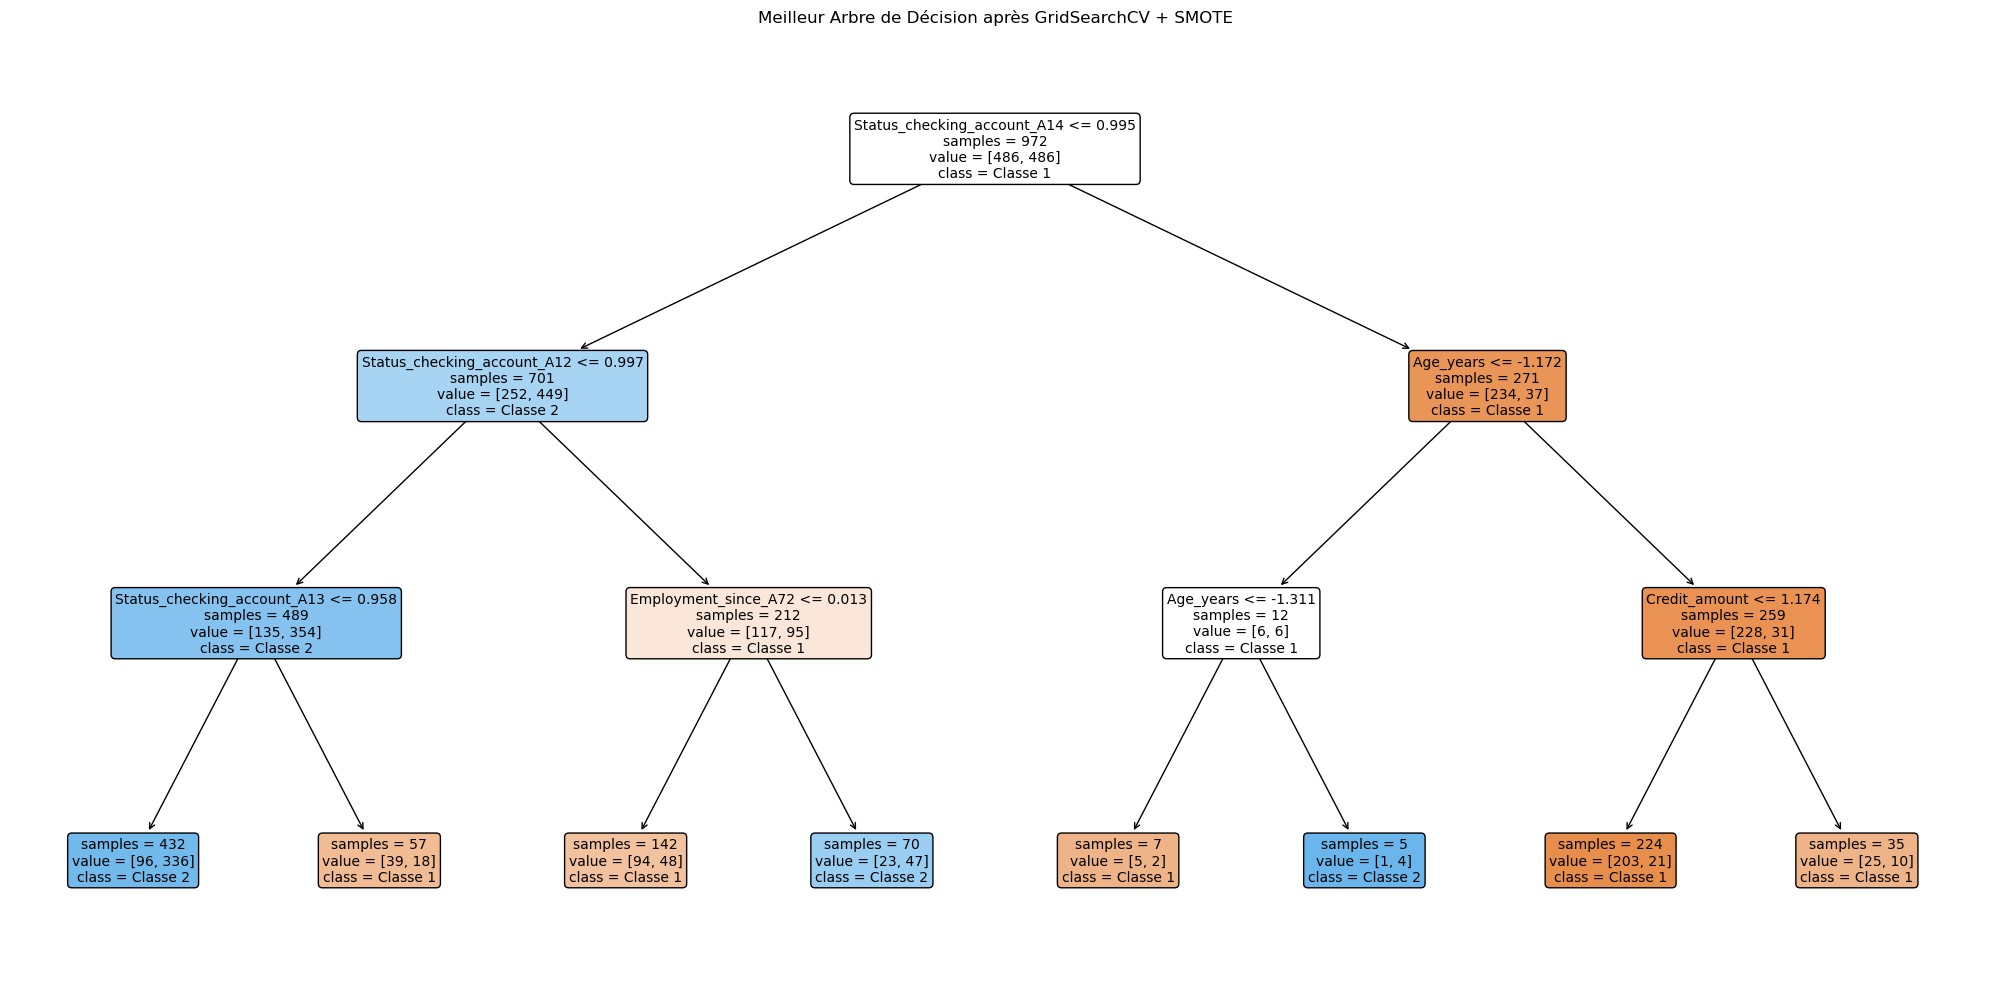

In [18]:
# Récupération du classifieur entraîné
best_tree = best_model.named_steps['classifier']

# Récupération des noms des features après encodage
feature_names_encoded = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
final_feature_names = numerical_features + list(feature_names_encoded)

# Affichage de l’arbre
plt.figure(figsize=(20, 10))
plot_tree(
    best_tree,
    feature_names=final_feature_names,
    class_names=['Classe 1', 'Classe 2'],  # Adapte selon tes classes
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3,
    impurity=False
)
plt.title("Meilleur Arbre de Décision après GridSearchCV + SMOTE")
plt.tight_layout()
plt.show()

In [19]:
model_dt = best_model 

## Étape 4 : Modélisation avec Rondom Forest

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

### Préparation des données

In [21]:
# Redétection des types de variables
categorical_features = X_cleaned.select_dtypes(include='object').columns.tolist()
numerical_features = X_cleaned.select_dtypes(exclude='object').columns.tolist()

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y_cleaned,
    test_size=0.2,
    random_state=42,
    stratify=y_cleaned
)

### Prétraitement (normalisation + encodage)

In [22]:
# Pipelines de transformation
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Assemblage des transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

 ### Pipeline complet avec SMOTE

In [23]:
# Pipeline final avec SMOTE et Random Forest
pipeline_with_smote = imbpipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

### Grille de recherche d’hyperparamètres

In [24]:
# Définition de la grille de paramètres
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced', 'balanced_subsample'],
}

### Recherche des meilleurs hyperparamètres

In [25]:
# Configuration de GridSearchCV
grid_search = GridSearchCV(
    pipeline_with_smote,
    param_grid,
    cv=5,
    scoring='recall_macro',
    n_jobs=-1,
    verbose=1
)

# Lancement de l'entraînement
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Duration_months',
                                                                          'Credit_amount',
                                                                          'Age_years']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Status_checking_account',
                                                                          'Credit_history',
                                                                          'Purpose',
                                                                          'Savings_account',
                                                                          'Employme...
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced',
                                                      'balanced_subsample'],
                         'classifier__max_depth': [4, 6, None],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='recall_macro', verbose=1)

 ### Évaluation du meilleur modèle

In [26]:
# Meilleur modèle trouvé
best_model = grid_search.best_estimator_
print("🏆 Meilleurs paramètres trouvés :", grid_search.best_params_)

# Prédiction sur le jeu de test
y_pred = best_model.predict(X_test)

# Rapport de classification
print("\n🎯 Performance du modèle optimisé avec SMOTE :")
print(classification_report(y_test, y_pred))

🏆 Meilleurs paramètres trouvés : {'classifier__class_weight': 'balanced', 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

🎯 Performance du modèle optimisé avec SMOTE :
              precision    recall  f1-score   support

           1       0.87      0.85      0.86       122
           2       0.62      0.66      0.64        44

    accuracy                           0.80       166
   macro avg       0.75      0.76      0.75       166
weighted avg       0.81      0.80      0.80       166



### Feature importance

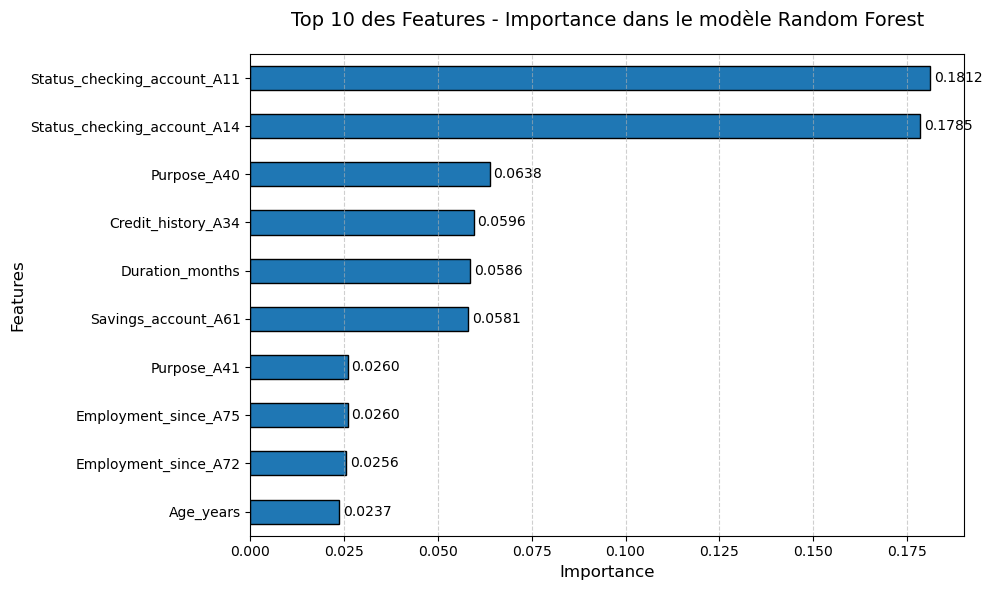

In [27]:
# Récupération des noms après encodage
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
feature_names_cat = ohe.get_feature_names_out(categorical_features).tolist()
feature_names_all = numerical_features + feature_names_cat

# Feature importances
importances = best_model.named_steps['classifier'].feature_importances_

# Création du DataFrame
feat_imp = pd.Series(importances, index=feature_names_all).sort_values(ascending=False)
# Top 10 pour le graphique
top_features = feat_imp.head(10)

# Nettoyage des noms pour une meilleure lisibilité (optionnel)
top_features.index = top_features.index.str.replace('x0_', '').str.replace('x1_', '')

# Création du graphique
plt.figure(figsize=(10, 6))
bars = top_features.plot(kind='barh', color='#1f77b4', edgecolor='black')  # Couleur professionnelle

# Titre et labels
plt.title("Top 10 des Features - Importance dans le modèle Random Forest", fontsize=14, pad=20)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Inverser l'axe Y pour avoir la feature la plus importante en haut
plt.gca().invert_yaxis()

# Grille subtile
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Ajouter les valeurs à côté des barres
for index, value in enumerate(top_features):
    plt.text(value + 0.001, index, f'{value:.4f}', va='center', fontsize=10)

# Ajustement final
plt.tight_layout()
plt.show()


### Matrice de confusion

<Figure size 600x500 with 0 Axes>

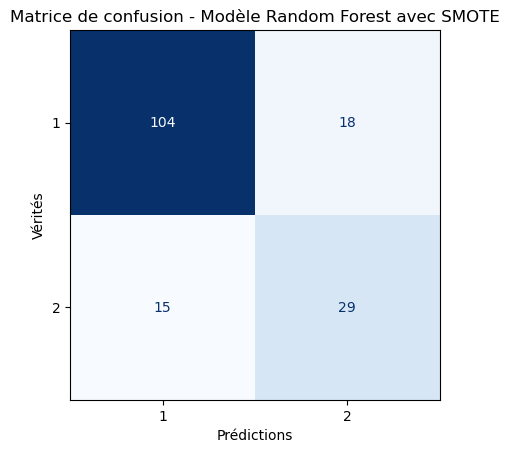

In [28]:
# Affichage de la matrice de confusion
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=best_model.classes_,
    cmap='Blues',
    colorbar=False
)
plt.title("Matrice de confusion - Modèle Random Forest avec SMOTE")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.grid(False)
plt.show()

### Cross-validation (avec plusieurs métriques)

In [29]:
# Cross-validation avec plusieurs métriques
scores = cross_validate(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'],
    return_train_score=False,
    n_jobs=-1
)

# Résumé des performances
summary = pd.DataFrame(scores).mean().round(3)
print("📊 Résumé des scores de cross-validation :\n", summary)

📊 Résumé des scores de cross-validation :
 fit_time                1.576
score_time              0.121
test_accuracy           0.739
test_recall_macro       0.696
test_precision_macro    0.679
test_f1_macro           0.683
dtype: float64


### Courbe ROC et AUC

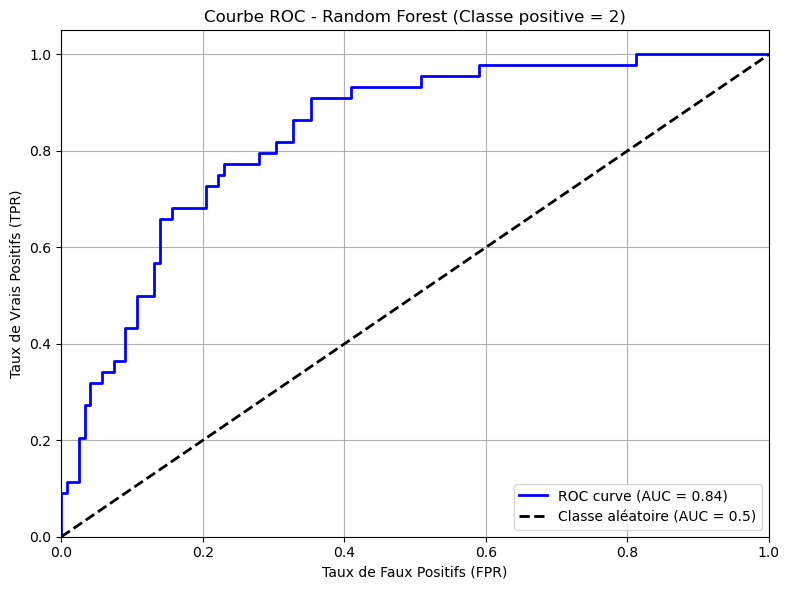

In [30]:
# Prédiction des probabilités
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=2)

# Calcul de l'AUC
auc_score = roc_auc_score(y_test, y_proba)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Classe aléatoire (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Random Forest (Classe positive = 2)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
model_rf = best_model

## Étape 5 : Modélisation avec la régression logestique

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

### Préparation des données

In [33]:
# Redétection des types de variables
categorical_features = X_cleaned.select_dtypes(include='object').columns.tolist()
numerical_features = X_cleaned.select_dtypes(exclude='object').columns.tolist()

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned,
    y_cleaned,
    test_size=0.2,
    random_state=42,
    stratify=y_cleaned
)

### Prétraitement

In [34]:
# Pipelines de transformation
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Assemblage des transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

### Pipeline avec SMOTE

In [35]:
# Pipeline final avec SMOTE et Régression Logistique
pipeline_logreg = imbpipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
])

### Grille de recherche

In [36]:
# Définition de la grille de paramètres
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10]
}

### Recherche des hyperparamètres

In [37]:
# Configuration de GridSearchCV
grid_search = GridSearchCV(
    pipeline_logreg,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Entraînement
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Duration_months',
                                                                          'Credit_amount',
                                                                          'Age_years']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Status_checking_account',
                                                                          'Credit_history',
                                                                          'Purpose',
                                                                          'Savings_account',
                                                                          'Employment_since',
                                                                          'Personal_status_sex',
                                                                          'Property',
                                                                          'Housing',
                                                                          'Telephone',
                                                                          'Foreign_worker'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='f1_macro', verbose=1)

 ### Évaluation du modèle

In [38]:
# Meilleur modèle trouvé
best_model = grid_search.best_estimator_
print("🏆 Meilleurs paramètres trouvés :", grid_search.best_params_)

# Prédiction sur le jeu de test
y_pred = best_model.predict(X_test)

# Performance
print("\n🎯 Performance du meilleur modèle :")
print(classification_report(y_test, y_pred))
print("✅ Accuracy sur le jeu de test :", accuracy_score(y_test, y_pred))

🏆 Meilleurs paramètres trouvés : {'classifier__C': 1, 'classifier__penalty': 'l2'}

🎯 Performance du meilleur modèle :
              precision    recall  f1-score   support

           1       0.89      0.77      0.82       122
           2       0.53      0.73      0.62        44

    accuracy                           0.76       166
   macro avg       0.71      0.75      0.72       166
weighted avg       0.79      0.76      0.77       166

✅ Accuracy sur le jeu de test : 0.7590361445783133


### Matrice de confusion

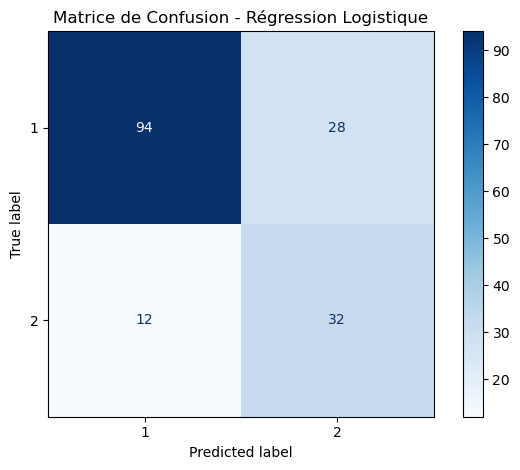

In [39]:
# Affichage de la matrice de confusion
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Matrice de Confusion - Régression Logistique")
plt.tight_layout()
plt.show()

### Feature importance (coefficients)

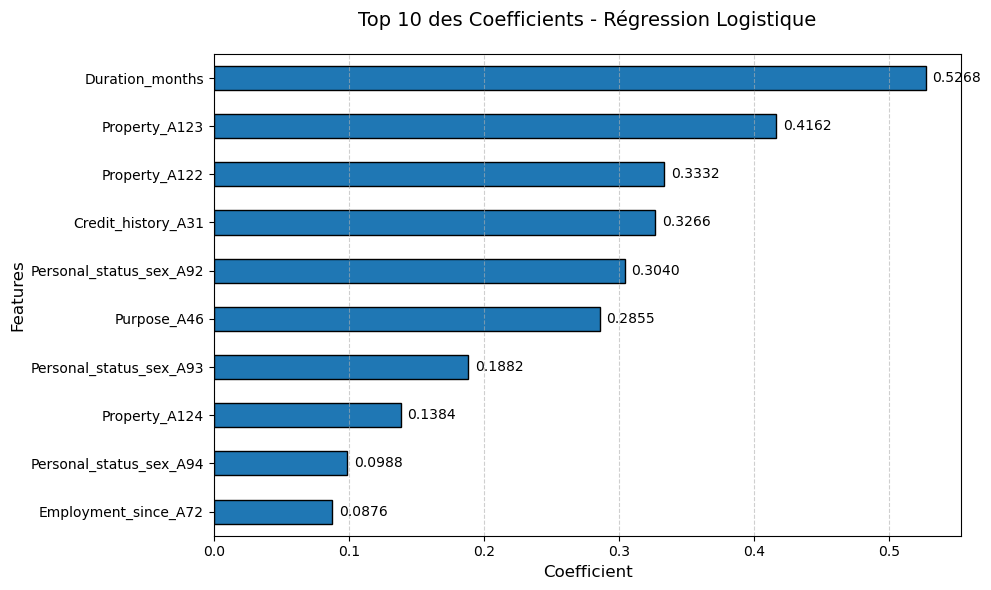

In [40]:
# Récupération des coefficients
model = best_model.named_steps['classifier']
coefs = model.coef_[0]

# Récupération des noms après encodage (version corrigée)
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
feature_names_cat = ohe.get_feature_names_out(categorical_features).tolist()
feature_names_all = numerical_features + feature_names_cat

# Création du DataFrame
feat_imp = pd.Series(coefs, index=feature_names_all).sort_values(ascending=False)

# Top 10 pour le graphique
top_features = feat_imp.head(10)

# Nettoyage des noms pour une meilleure lisibilité (optionnel)
top_features.index = top_features.index.str.replace('x0_', '').str.replace('x1_', '')

# Création du graphique
plt.figure(figsize=(10, 6))
bars = top_features.plot(kind='barh', color='#1f77b4', edgecolor='black')  # Couleur professionnelle

# Titre et labels
plt.title("Top 10 des Coefficients - Régression Logistique", fontsize=14, pad=20)
plt.xlabel("Coefficient", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Inverser l'axe Y pour avoir la feature la plus importante en haut
plt.gca().invert_yaxis()

# Grille subtile
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Ajouter les valeurs à côté des barres
for index, value in enumerate(top_features):
    plt.text(value + (0.005 if value >= 0 else -0.005), index, f'{value:.4f}', va='center', fontsize=10)

# Ajustement final
plt.tight_layout()
plt.show()

### Courbe ROC et AUC

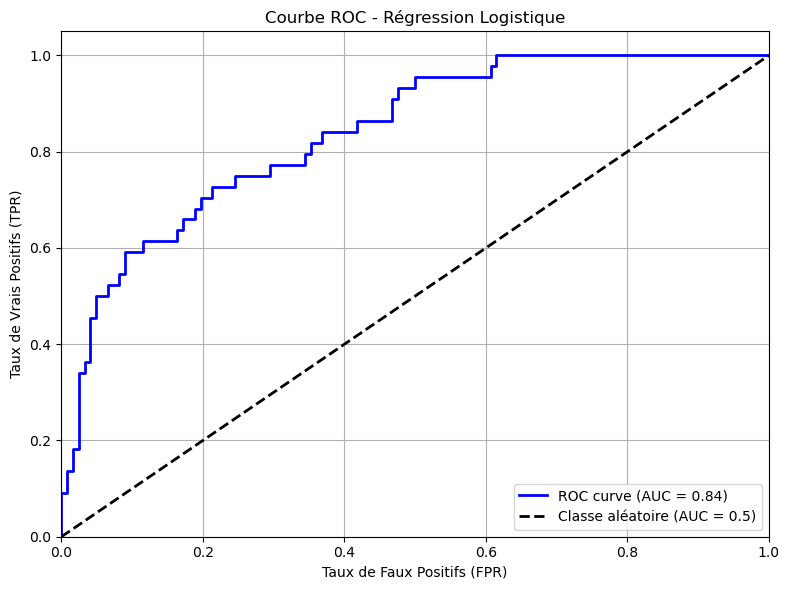

In [41]:

# Prédiction des probabilités
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=2)  # ou 1 selon tes classes

# Calcul de l'AUC
auc_score = roc_auc_score(y_test, y_proba)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Classe aléatoire (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC - Régression Logistique')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
model_lr = best_model

## Étape 6 : Comparaison entre les 3 modéles 

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [44]:
# Exemple (à adapter selon tes modèles)
y_pred_dt = model_dt.predict(X_test)   # Decision Tree
y_pred_rf = model_rf.predict(X_test)   # Random Forest
y_pred_lr = model_lr.predict(X_test)   # Logistic Regression

In [45]:
# Créer un DataFrame de comparaison
comparison = pd.DataFrame({
    'Modèle': ['Decision Tree', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_lr)
    ],
    'Precision (macro)': [
        precision_score(y_test, y_pred_dt, average='macro'),
        precision_score(y_test, y_pred_rf, average='macro'),
        precision_score(y_test, y_pred_lr, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_test, y_pred_dt, average='macro'),
        recall_score(y_test, y_pred_rf, average='macro'),
        recall_score(y_test, y_pred_lr, average='macro')
    ],
    'F1-score (macro)': [
        f1_score(y_test, y_pred_dt, average='macro'),
        f1_score(y_test, y_pred_rf, average='macro'),
        f1_score(y_test, y_pred_lr, average='macro')
    ]
}).round(3)

# Afficher le tableau stylé
print("\n📊 Comparaison des performances :")
display(comparison.style.background_gradient(cmap='Blues').format(precision=3))


📊 Comparaison des performances :


,Modèle,Accuracy,Precision (macro),Recall (macro),F1-score (macro)
0,Decision Tree,0.687,0.619,0.634,0.624
1,Random Forest,0.801,0.745,0.756,0.750
2,Logistic Regression,0.759,0.710,0.749,0.720


C:\Users\22226\AppData\Local\Temp\ipykernel_47068\3749373236.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


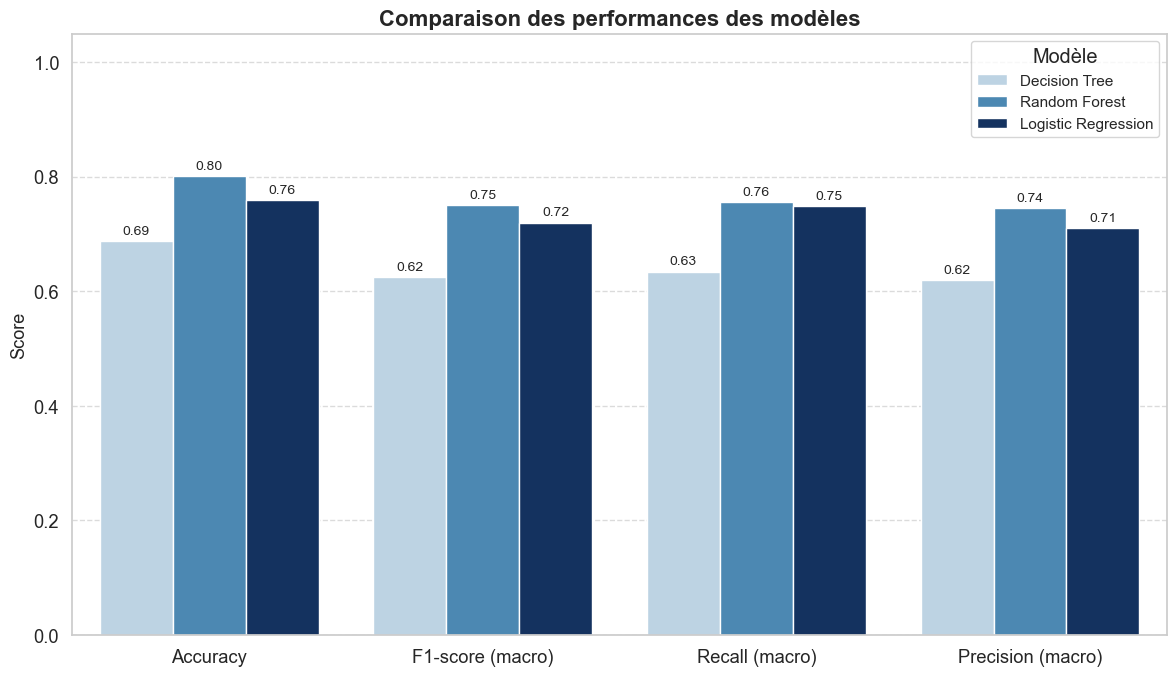

In [46]:
# Convertir en format long pour Seaborn
df_melted = comparison.melt(id_vars='Modèle',
                            value_vars=['Accuracy', 'F1-score (macro)', 'Recall (macro)', 'Precision (macro)'],
                            var_name='Métrique', value_name='Score')

# Palette de couleurs en nuances de bleu
cmap = cm.get_cmap('Blues')
num_models = df_melted['Modèle'].nunique()
colors = [cmap(0.3 + 0.7 * i / (num_models - 1)) for i in range(num_models)]

# Style pro et graphique
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 7))

ax = sns.barplot(data=df_melted, x='Métrique', y='Score', hue='Modèle', palette=colors)

# Valeurs au-dessus des barres
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=10)

# Personnalisation
plt.title("Comparaison des performances des modèles", fontsize=16, weight='bold')
plt.ylabel("Score", fontsize=13)
plt.xlabel("")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.legend(title="Modèle", loc='upper right', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Affichage final
plt.show()